In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

In [2]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem.txt", sep="\t")
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table
There are 514 samples in total, and there are 20531 genes in total.


In [3]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If there is NA values: False
There are 307 columns with the same value.
[136542, 317712, 728045, 728036, 255313, 728096, 728062, 653282, 728042, 57135]...


In [81]:
# thus, we need to drop all of same_value_cols: 
df_clean_1 = df_clean.drop(same_value_cols, axis = 1)
df_clean_1 = df_clean_1.T.drop_duplicates().T
df_clean_1.columns = df_clean_1.columns.astype("str")

In [70]:
## read patient data and preprocessing...
raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

In [82]:
df_sample_with_gene = df_clean_1.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
ge = sc.AnnData(X, obs = obs)
ge.var_names_make_unique()

In [83]:
ge.var_names

Index(['100130426', '100133144', '100134869', '10357', '10431', '155060',
       '26823', '280660', '340602', '388795',
       ...
       '55055', '11130', '7789', '158586', '79364', '440590', '79699', '7791',
       '23140', '26009'],
      dtype='object', length=20213)

In [84]:
ge.obs_names

Index(['TCGA-CS-4938', 'TCGA-CS-4941', 'TCGA-CS-4942', 'TCGA-CS-4943',
       'TCGA-CS-4944', 'TCGA-CS-5390', 'TCGA-CS-5393', 'TCGA-CS-5394',
       'TCGA-CS-5395', 'TCGA-CS-5396',
       ...
       'TCGA-VW-A8FI', 'TCGA-W9-A837', 'TCGA-WH-A86K', 'TCGA-WY-A858',
       'TCGA-WY-A859', 'TCGA-WY-A85A', 'TCGA-WY-A85B', 'TCGA-WY-A85C',
       'TCGA-WY-A85D', 'TCGA-WY-A85E'],
      dtype='object', name='PATIENT_ID', length=514)

computing PCA
    with n_comps=50
    finished (0:00:00)


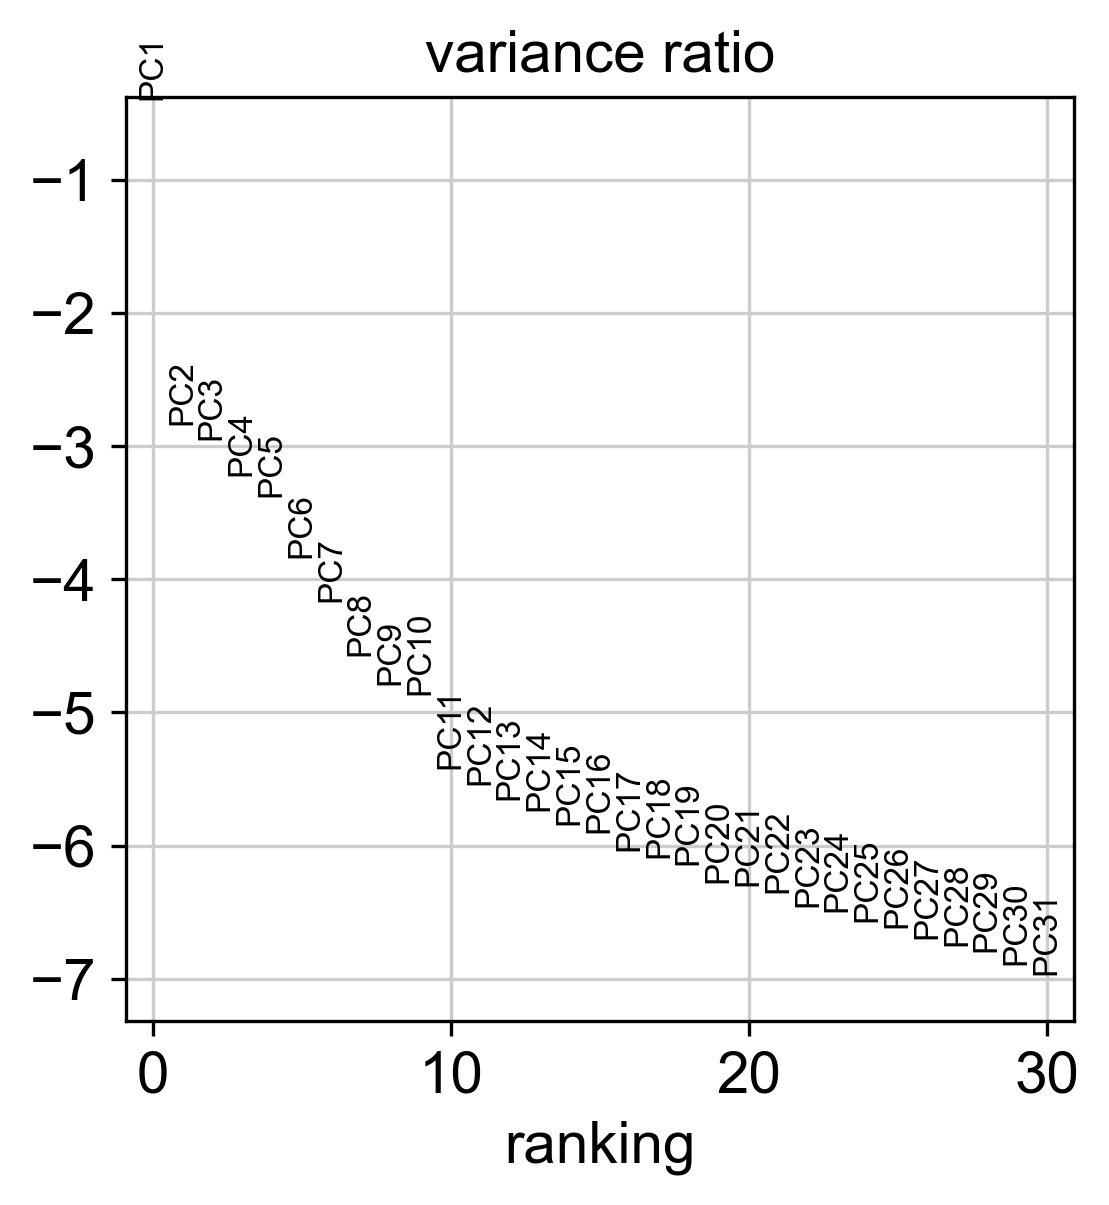

In [85]:
sc.tl.pca(ge, svd_solver='arpack')
sc.pl.pca_variance_ratio(ge, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


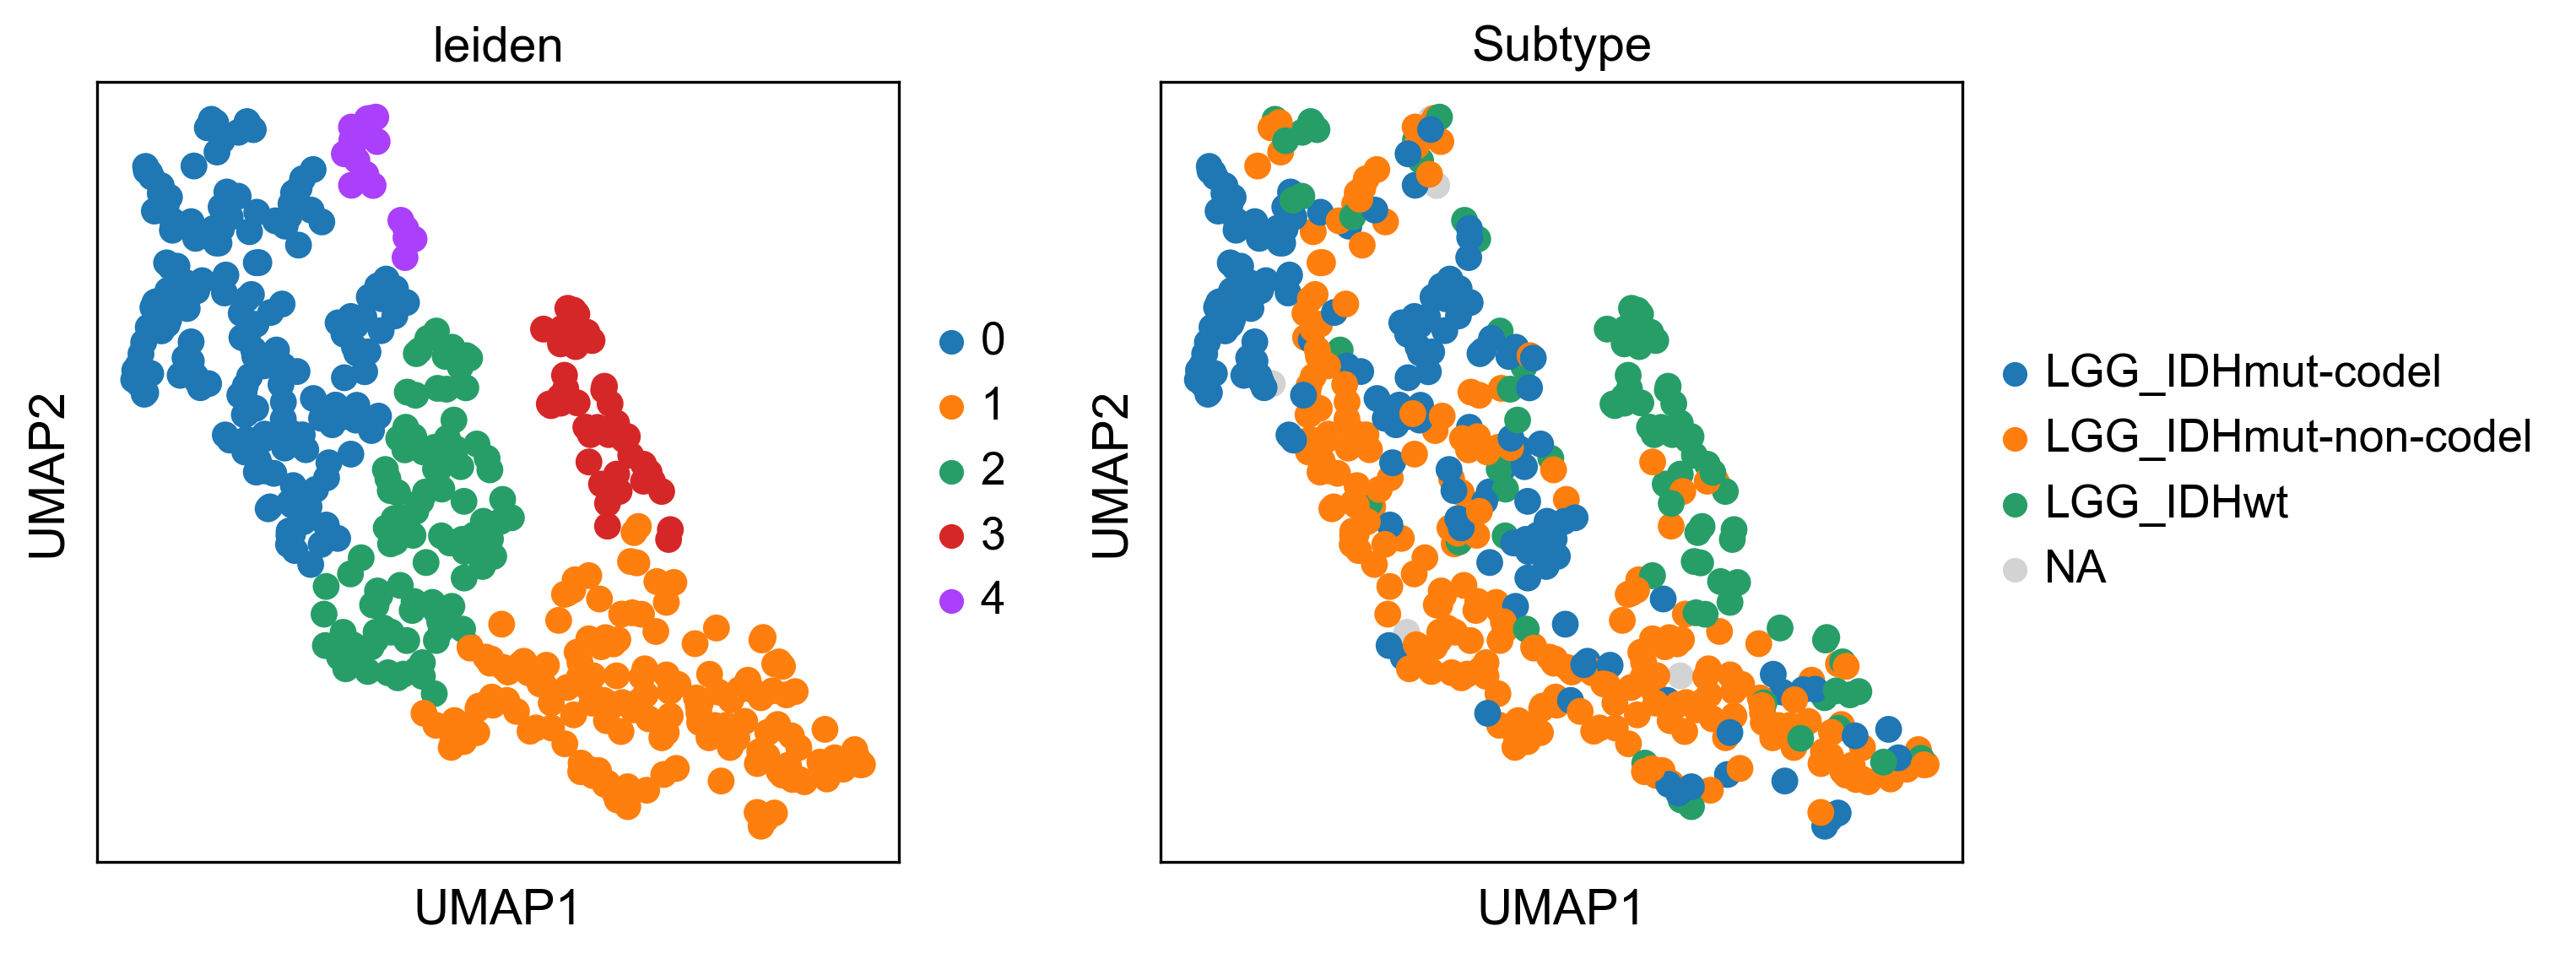

In [203]:
sc.pp.neighbors(ge, n_neighbors=5)
sc.tl.umap(ge, min_dist=0.3)
sc.tl.leiden(ge, resolution=0.20)
sc.pl.umap(ge, color = ["leiden", "Subtype"])

In [108]:
sc.tl.dendrogram(ge, groupby = 'leiden')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


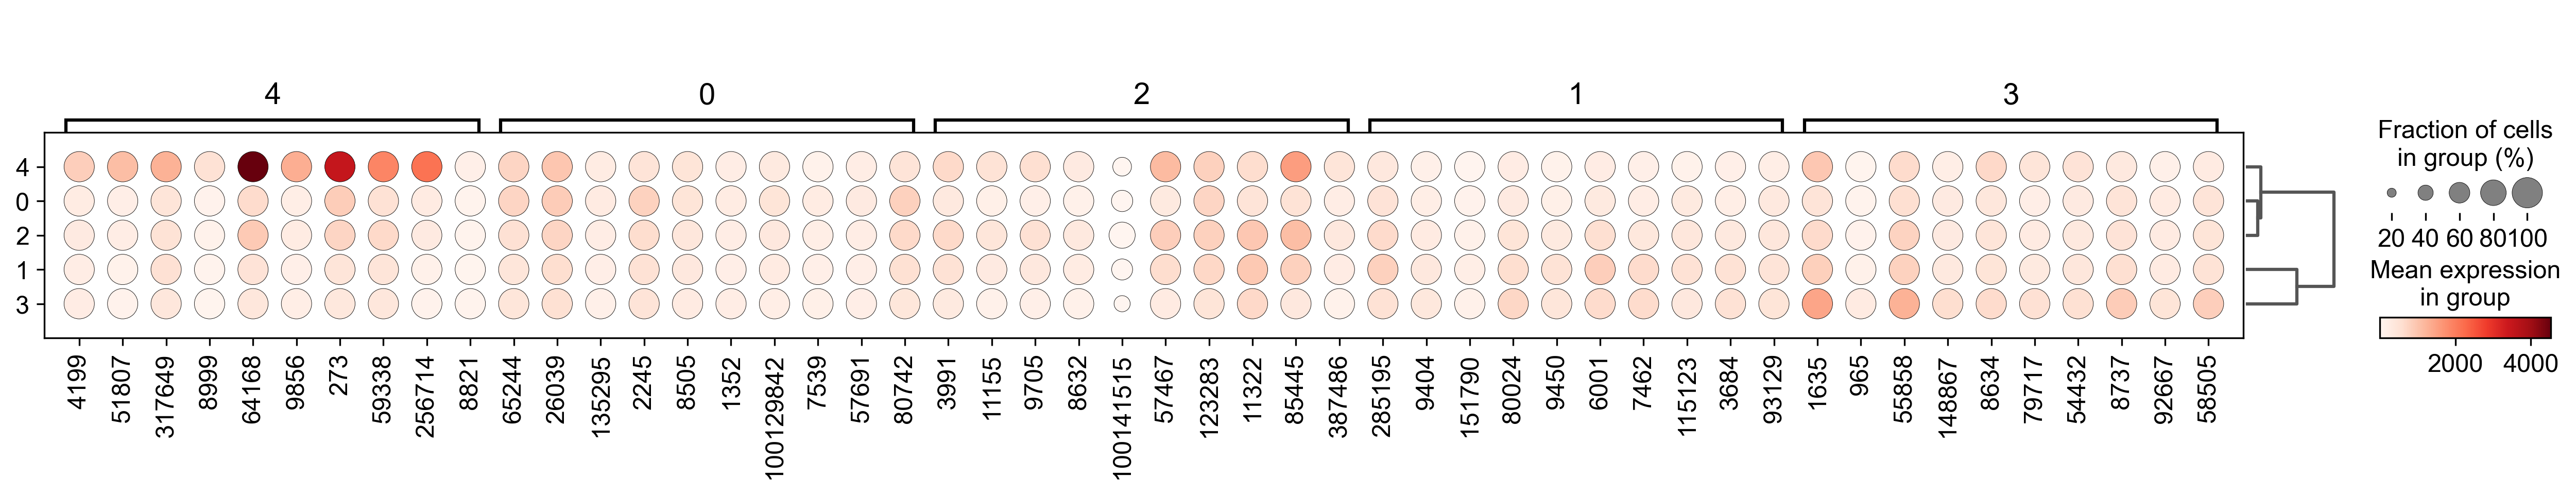

In [133]:
CLUSTER_COL = "leiden"
deg_key = f"tt_{CLUSTER_COL}"
sc.tl.rank_genes_groups(ge, groupby="leiden",method="t-test")
sc.pl.rank_genes_groups_dotplot(ge, min_logfoldchange=1, n_genes=10)

In [135]:
top_markers = pd.DataFrame(ge.uns['rank_genes_groups']['names']).head(10)
print(top_markers)

        0       1       2       3       4
0   65244    2670    3628    1635    4199
1     605   10580   94015     965   11275
2   26039    4134    5046    1495   57515
3    2786   55707   26030   55858   51807
4  135295    7030   23241  148867  317649
5    2245   79365   57475    8634    8999
6    7267   10066    9911    1650   64168
7   54700  285195    9625   79717    9856
8    8505    5660  124976   54432     273
9    1352    9404   23313   65220   11076


In [45]:
sc.pp.normalize_per_cell(ge, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [46]:
sc.pp.log1p(ge)

In [47]:
sc.pp.highly_variable_genes(ge, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


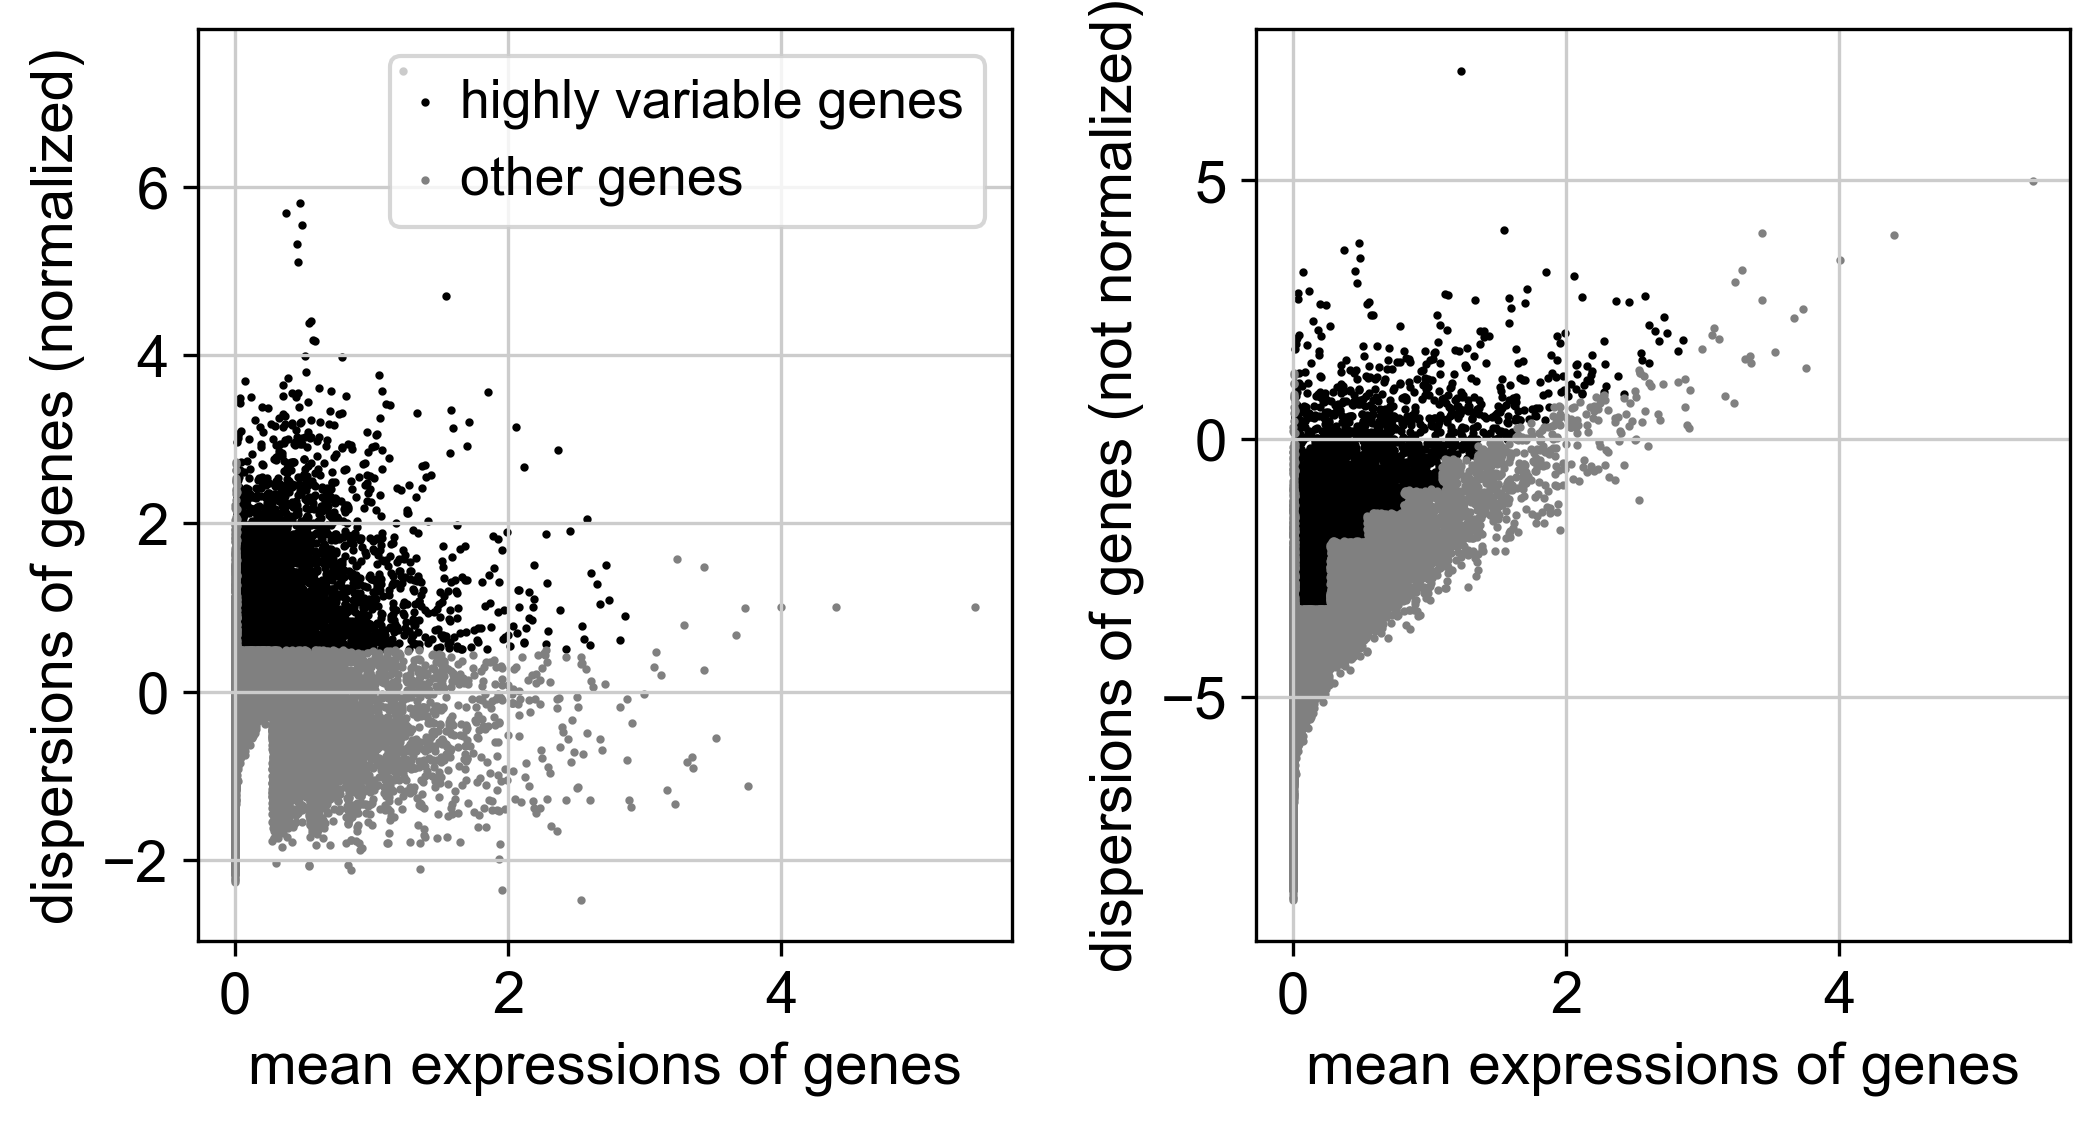

In [48]:
sc.pl.highly_variable_genes(ge)

In [49]:
ge.var[ge.var.highly_variable].sort_values(by = "dispersions_norm", ascending = False)

highly_variable     means  dispersions  dispersions_norm
7276               True  1.232021     7.128460          7.384197
1281               True  0.479474     3.783423          5.813167
283120             True  0.373135     3.653998          5.694025
1277               True  0.488897     3.490229          5.543268
5787               True  0.456796     3.249372          5.321548
...                 ...       ...          ...               ...
80298              True  0.227885    -3.293304          0.500294
3384               True  0.113531    -3.293406          0.500244
64170              True  0.048004    -3.293421          0.500237
1955               True  0.768835    -1.441959          0.500158
9980               True  0.224737    -3.293669          0.500115

[5540 rows x 4 columns]

In [206]:
df_clean

Entrez_Gene_Id   100130426  100133144  100134869  10357      10431      \
TCGA-CS-4938-01        0.0     8.7141    22.7523    268.576    845.815   
TCGA-CS-4941-01        0.0    36.4493    21.1767    156.687    390.269   
TCGA-CS-4942-01        0.0    11.8131    11.0242    185.138    621.453   
TCGA-CS-4943-01        0.0     8.6116     5.0835    269.836    835.729   
TCGA-CS-4944-01        0.0     0.0000    30.2610    216.341    812.508   
...                    ...        ...        ...        ...        ...   
TCGA-WY-A85A-01        0.0     5.4526    16.1890    124.919    658.221   
TCGA-WY-A85B-01        0.0     8.2616    19.7074    133.739    662.651   
TCGA-WY-A85C-01        0.0    11.5121    18.7291    120.924    524.724   
TCGA-WY-A85D-01        0.0     5.3895     8.9103    107.254    705.128   
TCGA-WY-A85E-01        0.0     9.9433     7.4480    143.006    748.582   

Entrez_Gene_Id   136542     155060     26823      280660     317712     ...  \
TCGA-CS-4938-01        0.0    182.505     0.4196        0.0        0.0  ...   
TCGA-CS-4941-01        0.0    325.052     1.7253        0.0        0.0  ...   
TCGA-CS-4942-01        0.0    131.142     0.0000        0.0        0.0  ...   
TCGA-CS-4943-01        0.0     83.475     0.3261        0.0        0.0  ...   
TCGA-CS-4944-01        0.0     80.696     0.0000        0.0        0.0  ...   
...                    ...        ...        ...        ...        ...  ...   
TCGA-WY-A85A-01        0.0    540.512     1.0557        0.0        0.0  ...   
TCGA-WY-A85B-01        0.0    610.155     2.1515        0.0        0.0  ...   
TCGA-WY-A85C-01        0.0    837.760     3.2693        0.0        0.0  ...   
TCGA-WY-A85D-01        0.0    805.720     0.4931        0.0        0.0  ...   
TCGA-WY-A85E-01        0.0   1194.330     1.1342        0.0        0.0  ...   

Entrez_Gene_Id   55055      11130      7789       158586     79364      \
TCGA-CS-4938-01    80.1636    50.3461    64.1913    523.180   1311.520   
TCGA-CS-4941-01   187.2980   110.4210   105.9350    467.564   1226.710   
TCGA-CS-4942-01   120.0310   186.5050   115.2250    454.325   1102.420   
TCGA-CS-4943-01   667.4480  1183.6500    89.0183    491.068   1288.320   
TCGA-CS-4944-01    57.3244    56.4872    42.3654    323.793   1012.730   
...                    ...        ...        ...        ...        ...   
TCGA-WY-A85A-01   101.8580    97.1233    53.8401    351.016   1263.130   
TCGA-WY-A85B-01   241.3380   349.3980    60.2410    503.012   1347.680   
TCGA-WY-A85C-01    96.6817    78.0548    76.4201    530.854   1556.190   
TCGA-WY-A85D-01    49.8570   111.9330    35.0099    312.130   1456.110   
TCGA-WY-A85E-01   221.1530   362.5710    55.5766    384.121    727.788   

Entrez_Gene_Id   440590     79699      7791       23140      26009      
TCGA-CS-4938-01     0.0000    1495.70    1598.91   1171.810    836.165  
TCGA-CS-4941-01     0.3451    1751.21    3889.92   1707.730   1015.530  
TCGA-CS-4942-01     0.3460    1586.16    2214.53   1423.880    706.920  
TCGA-CS-4943-01     3.2607    1760.15    2131.55   1916.990    689.321  
TCGA-CS-4944-01     0.5044    1225.07    1692.60    729.794    456.941  
...                    ...        ...        ...        ...        ...  
TCGA-WY-A85A-01     0.0000    1491.69    1497.49   1556.080    664.555  
TCGA-WY-A85B-01     0.8606    1443.63    1574.87   1685.890    836.919  
TCGA-WY-A85C-01     2.8606    1855.74    1927.67   2006.130    910.094  
TCGA-WY-A85D-01     0.0000    1222.88    1706.11   1429.490    771.203  
TCGA-WY-A85E-01     3.4026    1653.69    2043.86   1434.400    626.465  

[514 rows x 20531 columns]

In [131]:
marker_genes = {
    'T': ['915', '916'], # T cell
    'CD4': ['920'], # CD4 T cell
    'CD8': ['925', '926'], # CD8 T cell
    'B': ['931', '973', '930'], # B cell,
    'NK': ['4818', '4684', '22914'], # NK cell
    'Mono': ['929'], # CD14+ monocytes
    'Macrophage': ['968', '9332'], # macrophage
    'Dendritic': ['2322', '2205'], # dendritic
}

# flatten the genes
marker_genes_list = [v2 for v in marker_genes.values() for v2 in v]

categories: 0, 1, 2, etc.
var_group_labels: T, CD4, CD8, etc.


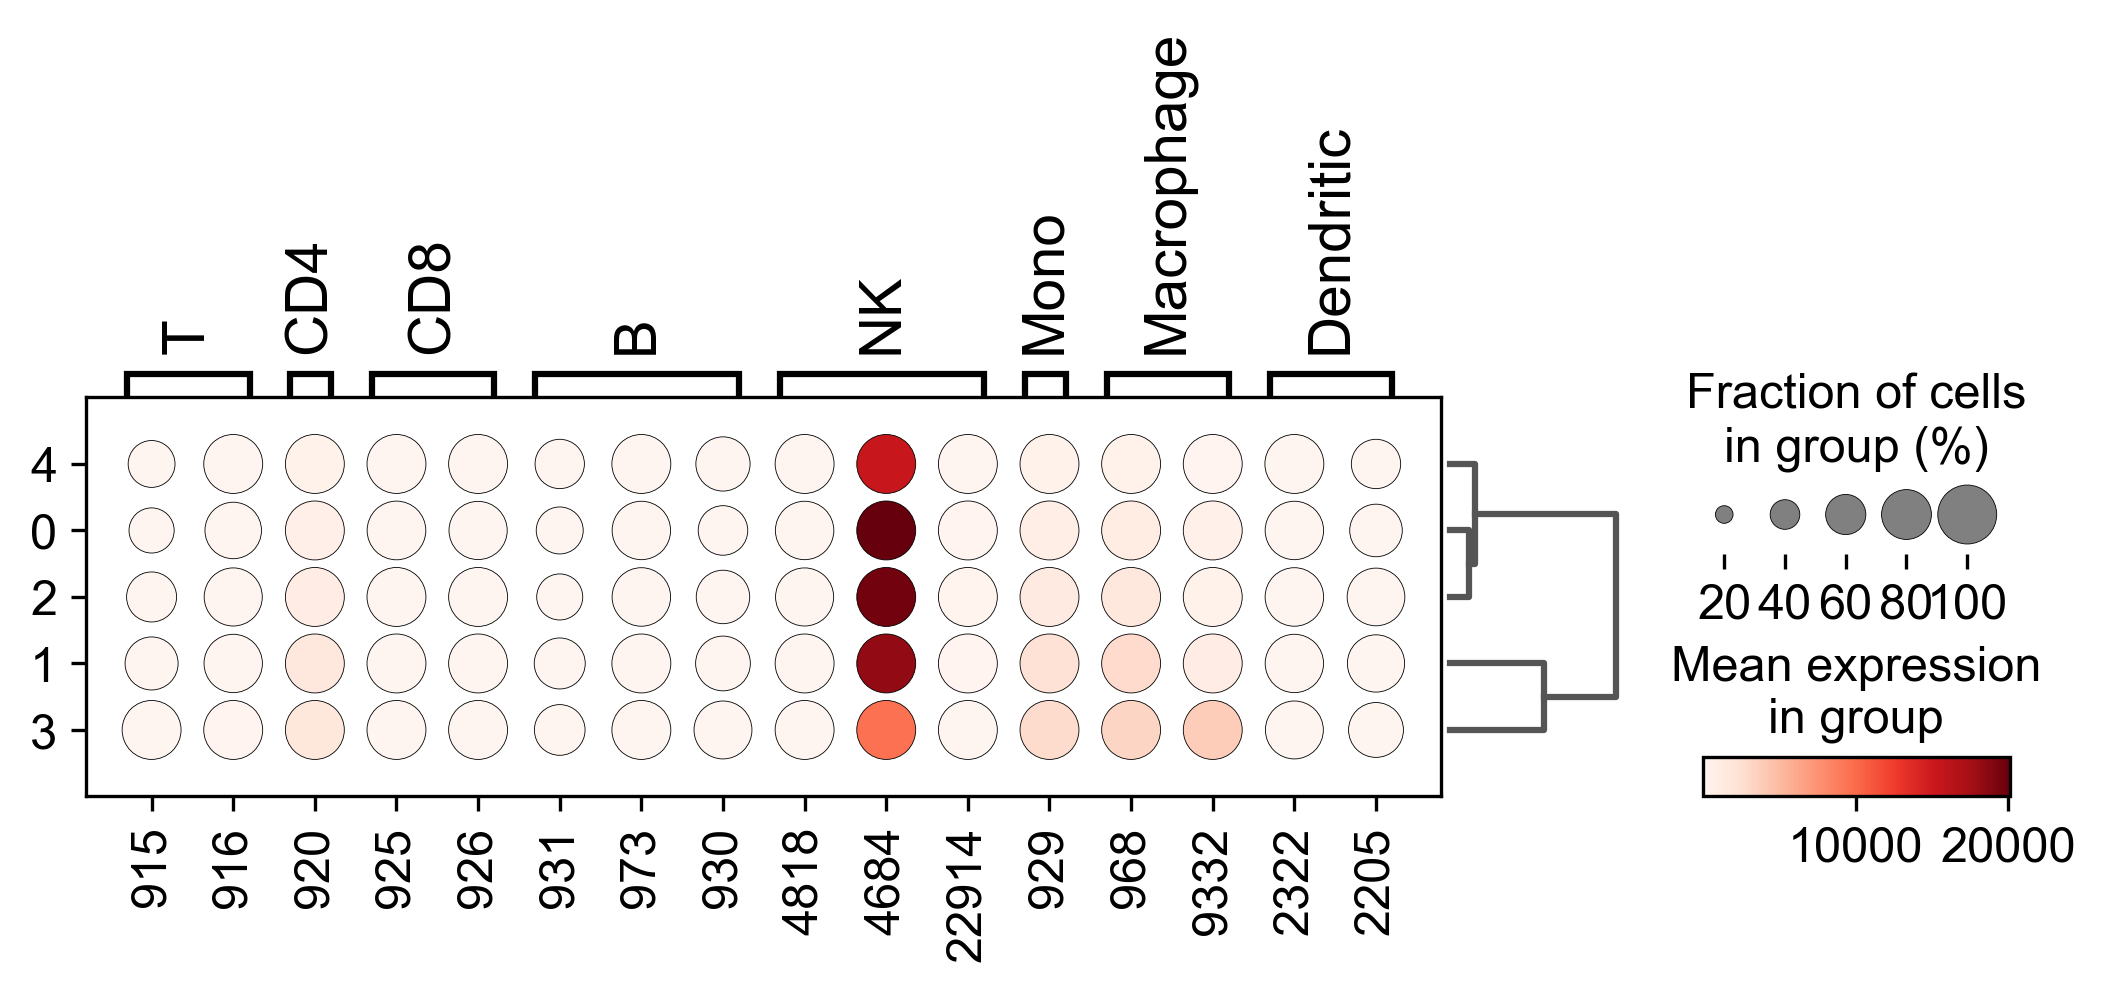

In [132]:
sc.pl.dotplot(ge, marker_genes, groupby=CLUSTER_COL, dendrogram=True)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


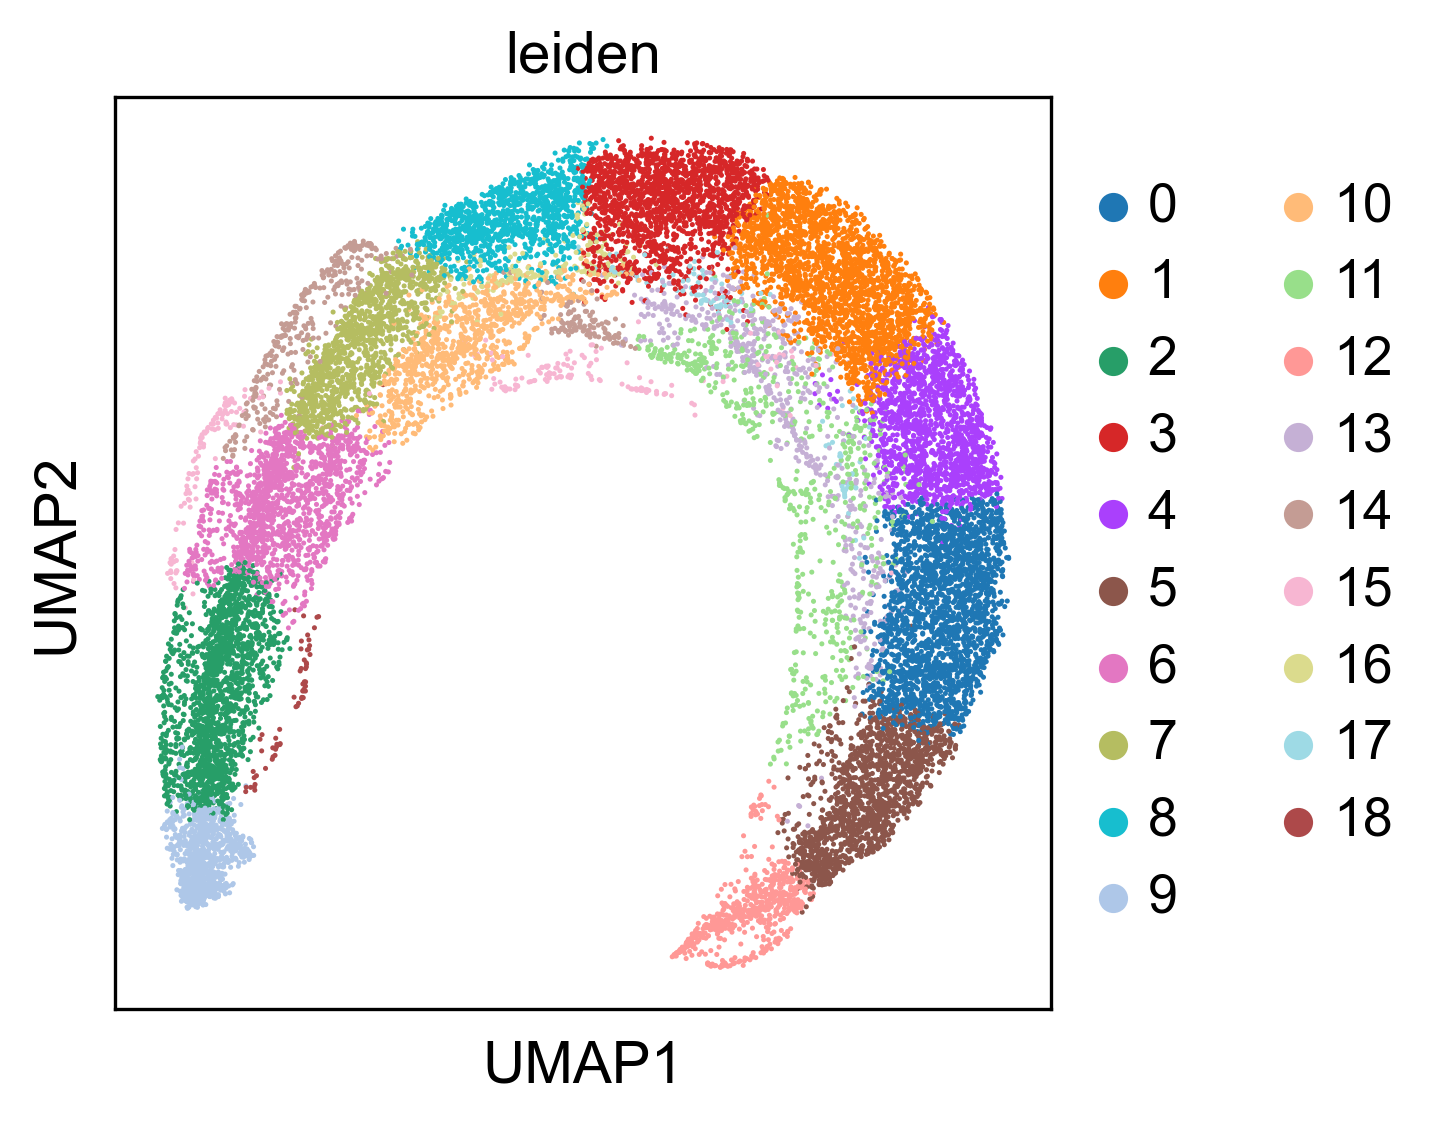

In [138]:
import pyclusterprofiler
# can I use umap to cluster genes? 
df_gene = df_clean_1.transpose()
adata_gene = sc.AnnData(df_gene)
sc.tl.pca(adata_gene, svd_solver='arpack')
sc.pp.neighbors(adata_gene, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_gene, min_dist=0.3)
sc.tl.leiden(adata_gene)
sc.pl.umap(adata_gene, color = "leiden")

In [145]:
df_gene_cluster = adata_gene.obs
df_gene_cluster = df_gene_cluster.reset_index()
df_gene_cluster.columns = ["gene_id", "cluster"]

In [149]:
df_enrichment = pyclusterprofiler.compare_clusters(df_gene_cluster,'cluster',database='GO')

FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
  gunzip gene2go.gz
HMS:0:00:07.141835 342,316 annotations, 20,739 genes, 18,984 GOs, 1 taxids READ: gene2go 
requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

go-basic.obo: fmt(1.2) rel(2023-03-06) 46,579 GO Terms
  EXISTS: gene2go
HMS:0:00:06.556501 342,316 annotations, 20,739 genes, 18,984 GOs, 1 taxids READ: gene2go 
84915 not found in database
28974 not found in database
127687 not found in database
79640 not found in database
257407 not found in database
51372 not found in database
22982 not found in database
283991 not found in database
83641 not found in database
64760 not found in database
64319 not found in database
440465 not found in database
400322 not found in database
3653 not found in database
57291 not found in database
158358 not found in database
147727 not found in database
151162 not found in database
339047 not found in database
399959 not found in datab

In [150]:
significant_pathways = (df_enrichment.query('(corrected_pvalue<0.05)&(cluster_pathway_genes>3)')['pathway'].unique())

In [207]:
df_query = df_enrichment.query('pathway in @significant_pathways')

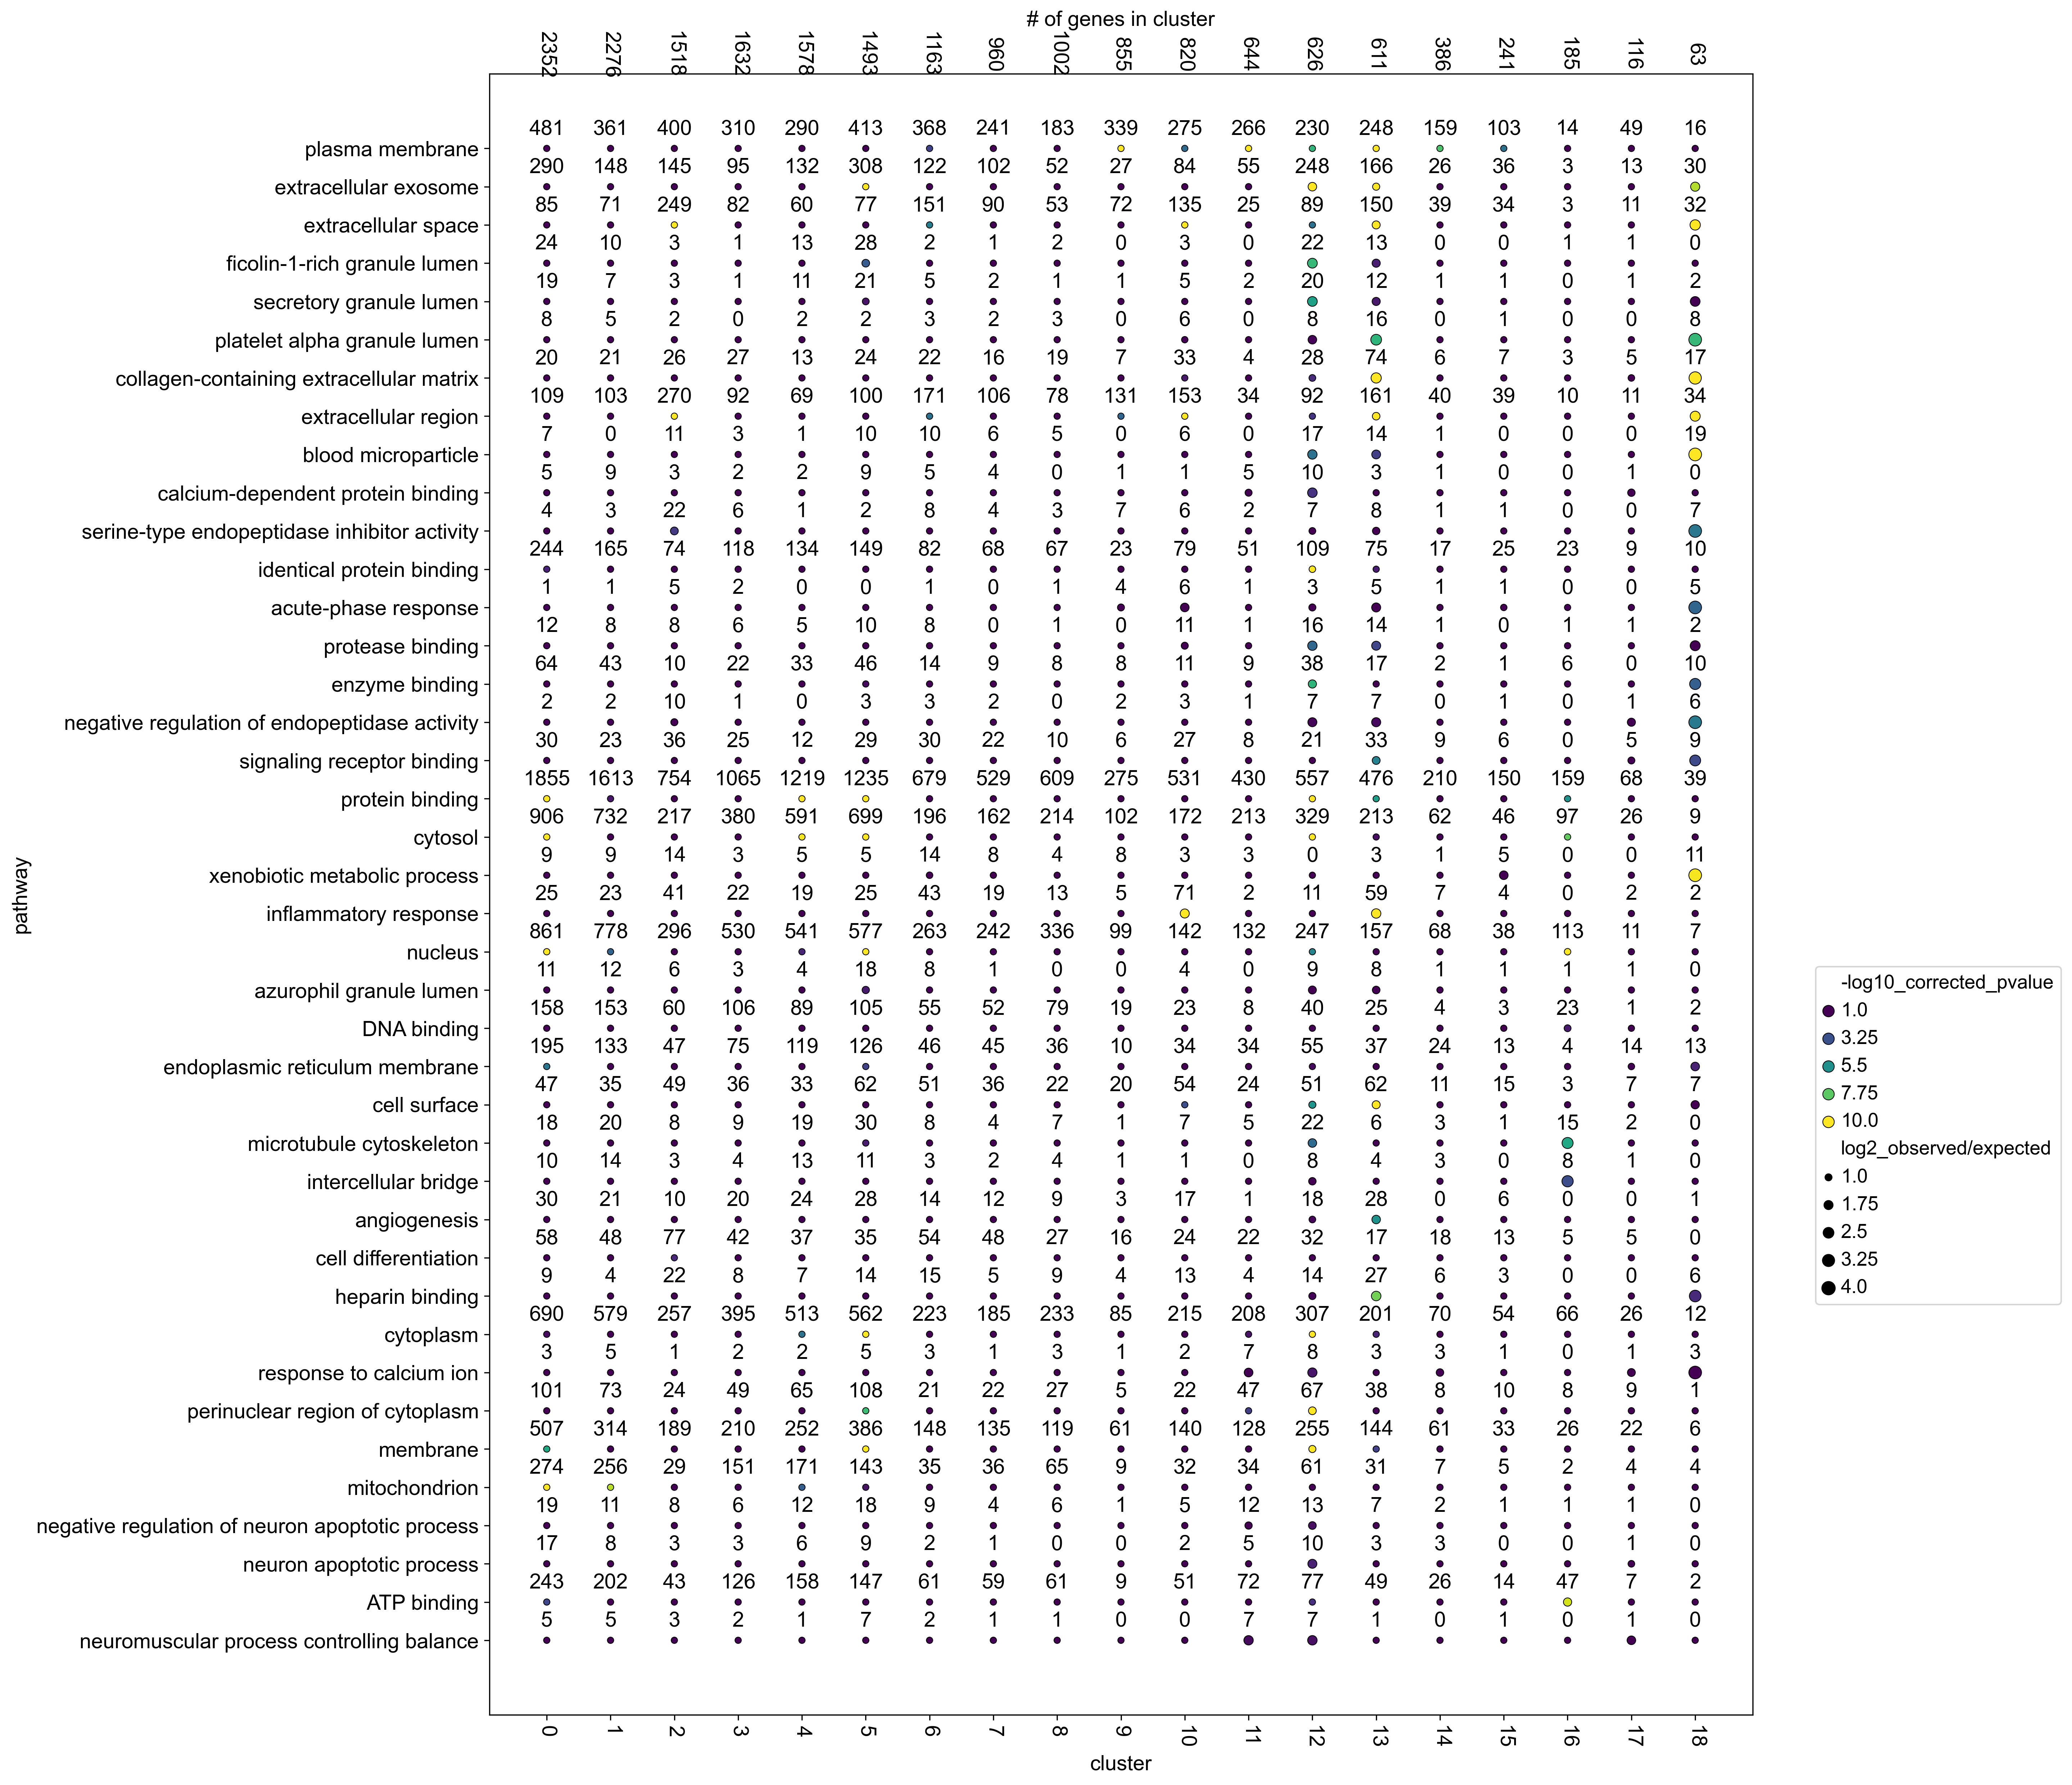

In [198]:
ax = pyclusterprofiler.dotplot(df_query.iloc[0:760,:], figsize = (15,20), size_norm = (1,4))